# Kaggle 2018: Home Loan Credit

This project serves as the Capstone Project I of my SpringBoard Data Science Career Track curriculum. The objective is to demonstrate what I have learnt so-far from SpringBoard courses, and the implementation to a real-word dataset and problem. The dataset is from [Kaggle Competition: Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk). Although there are many data file available, I will only make use one of the major dataset "application_{train|test}.csv" during this project to limit my scope. Further exploration and integration of the other datasets will be done in the future, or possibly my next Capstone Project. 

The key question that I am trying to answer is: 
* What are the factors contributing to the credibility of indivudal home loan applicant? 


In [1]:
%pwd

'C:\\Users\\zb\\Dropbox\\development\\kaggle-2018-home-credit\\notebooks'

## Loading Libraries

### standard packages

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import os
from tqdm import tqdm  # time for-loops, for i in tqdm(range(10000)):
import time
# feature preparation
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from scipy import interp
from sklearn.model_selection import StratifiedKFold

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier


from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


from sklearn.model_selection import RandomizedSearchCV

%load_ext watermark
%watermark -a "author name" -d -t -v -p numpy,pandas,sklearn,matplotlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
author name 2019-02-26 22:59:22 

CPython 3.6.8
IPython 7.2.0

numpy 1.15.2
pandas 0.24.1
sklearn 0.20.1
matplotlib 3.0.2


### customized modules

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# load my functions
import sys
sys.path.insert(0, '../src') # use absolute directory

In [4]:
from data import * # functions for data manipulation and mostly during EDA stage
from features import * # functions for visualization
from visualization import * # functions for visualization

## User Inputs

In [5]:
dir_dat_raw = "../data/raw/"
dir_dat_interim = "../data/interim/"
dir_dat_processed = "../data/processed/"

dir_reports = "../reports/"
dir_reports_figures = "../reports/figures/"

fname_dat_raw = "application_train.csv"
fname_dat_interim = "application_train.pickle"

### Read data and save in pickle format

In [79]:
# # read raw data
# df_raw = pd.read_csv(dir_dat_raw + fname_dat_raw)

# # # save to pickle
# with open(dir_dat_interim+fname_dat_interim, 'wb') as handle:
#     pickle.dump(df_raw, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # read from pickle
with open(dir_dat_interim+fname_dat_interim, 'rb') as handle:
    df_raw = pickle.load(handle)

In [40]:
df_raw.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Exploratory Data Analysis (EDA)

1. Check the consistency of data type, overall statistics 
1. Deal with missing values and outliers. 
1. Check the distribution of features and the correlation with the label variable.
1. Check the colinearity among features. 


### Data Type and Statistics
It is found that all the string variables are nominal categorical variables, which requires one-hot encoding. 


#### summarize statistics, examine data type

In [9]:
# summarize: statistics | missing value | data type | sample data
df_raw_stat = pd.concat([pd.DataFrame(df_raw.dtypes,columns=['type']), func_df_describe_all(df_raw),df_raw.head().T], axis=1)
df_raw_stat.to_excel('../reports/EDA-data-summary.xlsx', sheet_name='statistics', index=True)
func_df_display_all(df_raw_stat)

,type,count,unique,top,freq,mean,std,min,25%,50%,75%,max,miss_perc,0,1,2,3,4
SK_ID_CURR,int64,307511,NaN,NaN,NaN,278181,102790,100002,189146,278202,367142,456255,0.000000,100002,100003,100004,100006,100007
TARGET,int64,307511,NaN,NaN,NaN,0.0807288,0.272419,0,0,0,0,1,0.000000,1,0,0,0,0
NAME_CONTRACT_TYPE,object,307511,2,Cash loans,278232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans
CODE_GENDER,object,307511,3,F,202448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,M,F,M,F,M
FLAG_OWN_CAR,object,307511,2,N,202924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,N,N,Y,N,N
FLAG_OWN_REALTY,object,307511,2,Y,213312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,Y,N,Y,Y,Y
CNT_CHILDREN,int64,307511,NaN,NaN,NaN,0.417052,0.722121,0,0,0,1,19,0.000000,0,0,0,0,0
AMT_INCOME_TOTAL,float64,307511,NaN,NaN,NaN,168798,237123,25650,112500,147150,202500,1.17e+08,0.000000,202500,270000,67500,135000,121500
AMT_CREDIT,float64,307511,NaN,NaN,NaN,599026,402491,45000,270000,513531,808650,4.05e+06,0.000000,406598,1.2935e+06,135000,312682,513000
AMT_ANNUITY,float64,307499,NaN,NaN,NaN,27108.6,14493.7,1615.5,16524,24903,34596,258026,0.003902,24700.5,35698.5,6750,29686.5,21865.5


#### scan data types and save a copy

In [42]:
# feature_dict, feature_df = func_df_col_names_by_type(df_raw)

# with open(dir_dat_processed+'/feature_names.pickle', 'wb') as handle:
#     pickle.dump([feature_dict, feature_df], handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load data 
with open(dir_dat_processed+'/feature_names.pickle', 'rb') as handle:
    [feature_dict, feature_df] = pickle.load(handle)

feature_df

,feature_type,feature_num,feature_list
0,cols_number,105,"[SK_ID_CURR, CNT_CHILDREN, AMT_INCOME_TOTAL, A..."
1,cols_string,16,"[NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR..."
2,cols_binary,32,"[FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, ..."
3,cols_number_exclude_binary,73,"[SK_ID_CURR, CNT_CHILDREN, AMT_INCOME_TOTAL, A..."
4,cols_string_include_binary,48,"[NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR..."
5,cols_datetime,0,[]
6,cols_timedelta,0,[]
7,cols_category,0,[]
8,cols_others,0,[]


#### levels within categorical features

In [11]:
df_cat = func_df_cat_levels(df_raw[feature_dict['cols_string']])
df_cat

,features,level_num,levels
0,NAME_CONTRACT_TYPE,2,"[Cash loans, Revolving loans]"
2,FLAG_OWN_CAR,2,"[N, Y]"
3,FLAG_OWN_REALTY,2,"[Y, N]"
15,EMERGENCYSTATE_MODE,2,"[No, nan, Yes]"
1,CODE_GENDER,3,"[M, F, XNA]"
13,HOUSETYPE_MODE,3,"[block of flats, nan, terraced house, specific..."
12,FONDKAPREMONT_MODE,4,"[reg oper account, nan, org spec account, reg ..."
6,NAME_EDUCATION_TYPE,5,"[Secondary / secondary special, Higher educati..."
7,NAME_FAMILY_STATUS,6,"[Single / not married, Married, Civil marriage..."
8,NAME_HOUSING_TYPE,6,"[House / apartment, Rented apartment, With par..."


### Distributions 

#### y-label: check dataset balance 
Observation: ~8% data labeled as 'default' cases. <br>
Implecation: consider upsampling the minority class during model training. 

0    91.927118
1     8.072882
Name: TARGET, dtype: float64


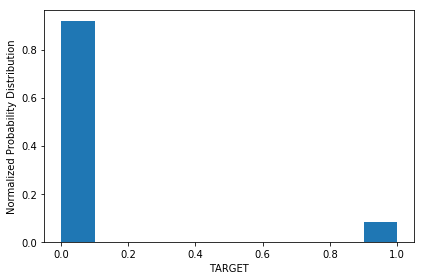

In [21]:
col = 'TARGET'
print(df_raw[col].value_counts(normalize=True) * 100)
fig = plt.figure(figsize=[6,4])
plt.hist(df_raw[col], weights=np.ones(df_raw[col].count()) / df_raw[col].count())  # .count() excludes NaN
plt.xlabel(col)
plt.ylabel('Normalized Probability Distribution')
plt.tight_layout()
plt.savefig(dir_reports_figures+'eda-target-'+col+'.png')
plt.show()

#### Histogram

In [43]:
def func_eda_hist_by_label_plot(df_X, Y, prefix='', figsize=(6,4), dir_png='../reports/figures/'):
    """function to plot the normalized probability density distribution
    Keyword arguments: df_X (feature dataframe), y (label pandas series), dir_png (output dir); Return: PNG files
    """
    import numpy as np
    
    y_uniques = Y.unique()  # unique labels, e.g. 0 or 1
    
    for col in df_X.columns:
        # filter nan vales 
        mask = ~df_X[col].isnull()
        x = df_X.loc[mask, col]
        y = Y[mask]
        
        # plot
        fig = plt.figure(figsize=figsize)
        plt.hist([x[y == y_unique] for y_unique in y_uniques], 
                 label=y_uniques, 
                 weights=[np.ones(x[y == y_unique].count()) / x[y == y_unique].count() for y_unique in y_uniques])#density=True)
        plt.xlabel(col)
        plt.ylabel('Normalized Probability Distribution')
        plt.legend()
        plt.tight_layout()
#         plt.savefig(dir_reports_figures+'eda-hist-'+prefix+col+'.png')
#         plt.close(fig)
        plt.show()
    
    return

In [23]:
# Loop through all parameters
# # plot the normalized probability density function colored by y 
# func_eda_df_hist_by_label(df_raw[feature_dict['cols_string']], df_raw['TARGET'], 
#                           normal=True, prefix='density-str-', dir_png='../reports/figures/')
# func_eda_df_hist_by_label(df_raw[feature_dict['cols_number']], df_raw['TARGET'], 
#                           normal=True, prefix='density-num-', dir_png='../reports/figures/')

By plotting the normalized probability density distribution colored by TARGET label, most distributions are found to have similar distributions, thus no correlation with the label. The following features are found to have relatively more distinct distributions under 'default' (y=1) and 'normal' (y=0) cases. 
* 'DAYS_BIRTH','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CODE_GENDER'

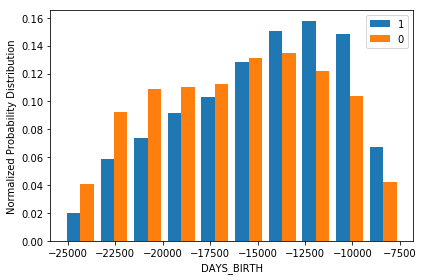

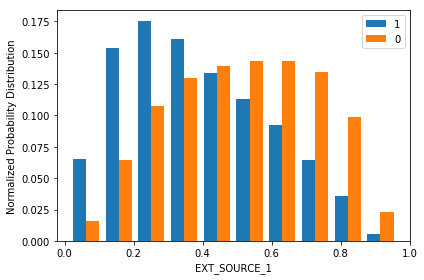

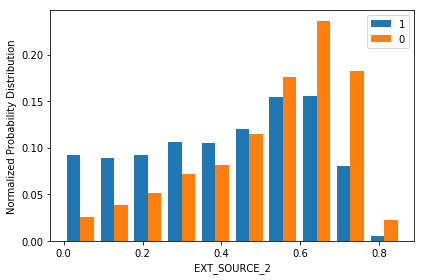

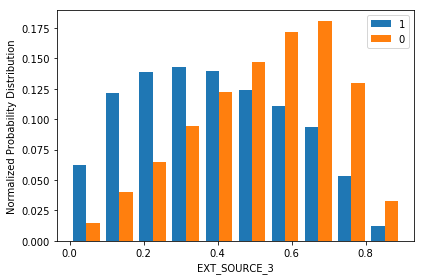

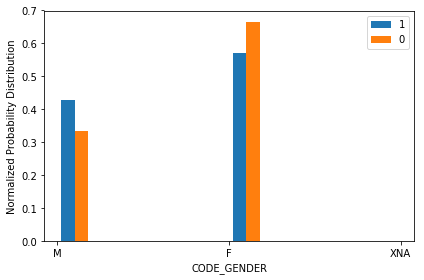

In [44]:
# the plots below lists down the features that have 
cols_temp = ['DAYS_BIRTH','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CODE_GENDER']
func_eda_hist_by_label_plot(df_raw[cols_temp], df_raw['TARGET'])

#### Box plot for continuous variable to detect outliers

In [56]:
# Loop through all parameters
# func_eda_df_box_plot(df_raw[feature_dict['cols_number_exclude_binary']], 
#                      prefix='', figsize=(12,2), dir_png='../reports/figures/eda-box/')

By plotting the boxplots, we can identify that 'DAYS_EMPLOYED' contains outliers with value = 365243 days, which obviously represents erroneous data, as the days are defined as negative values. 

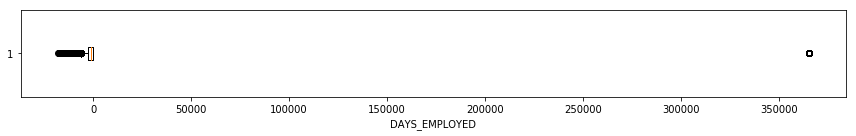

In [76]:
# # the plots below lists down the features that have 
cols_temp = ['DAYS_EMPLOYED']
for col in cols_temp:
    fig = plt.figure(figsize=(12,2))
    plt.boxplot(df_raw[col].dropna(), vert=False)
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

Check the boxplot again after replacing outliers with median value. 

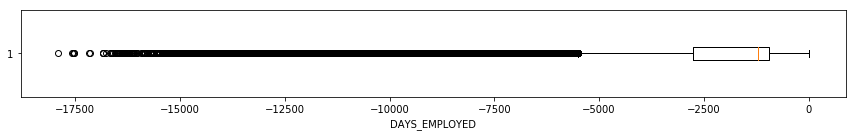

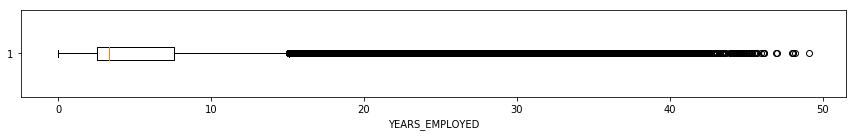

In [48]:
# # replace outliers with median
median_value = df_raw['DAYS_EMPLOYED'].median(skipna=True)
data = df_raw['DAYS_EMPLOYED'].replace(to_replace=365243, value = median_value, inplace=False)
filtered_data = data[~np.isnan(data)]
fig = plt.figure(figsize=(12,2))
plt.boxplot(filtered_data, vert=False)
plt.xlabel('DAYS_EMPLOYED')
plt.tight_layout()
plt.show()

# convert 'DAYS_EMPLOYED' into 'YEARS_EMPLOYED'
fig = plt.figure(figsize=(12,2))
plt.boxplot(-filtered_data/365, vert=False)
plt.xlabel('YEARS_EMPLOYED')
plt.tight_layout()
plt.show()

All features in units of Days as below. Only 'DAYS_EMPLOYED' show abnormal results. 

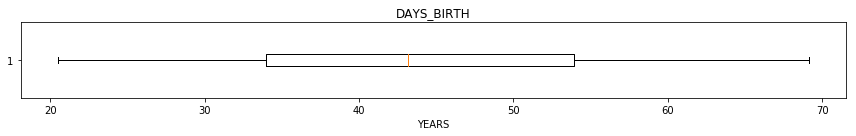

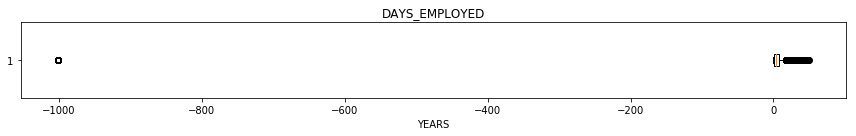

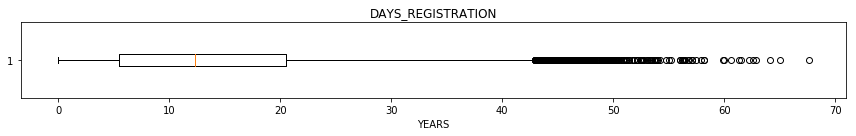

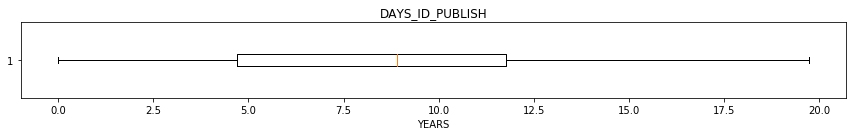

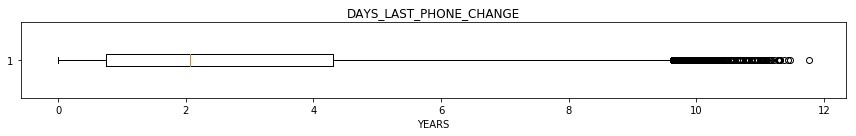

In [75]:
col_in_days = [x for x in df_raw.columns.values if 'days' in x.lower()]

for c in col_in_days:
    fig = plt.figure(figsize=(12,2))
    plt.boxplot(-df_raw[c].dropna()/365, vert=False)
    plt.title(c)
    plt.xlabel('YEARS')
    plt.tight_layout()
    plt.show()

### Missing Values 

#### Correlation of missing values 

In [65]:
# find the correlation of missing values for features with high missing value percentages
percent_missing = df_raw.isnull().sum() * 100 / len(df_raw)
col_names = df_raw.columns

Missing value heatmap saved at ../reports/figures/eda-missingno-heatmap-above60perc.png


C:\Users\Admin\Anaconda3\lib\site-packages\matplotlib\figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Missing value heatmap saved at ../reports/figures/eda-missingno-correlation-above60perc.png


<Figure size 1008x576 with 0 Axes>

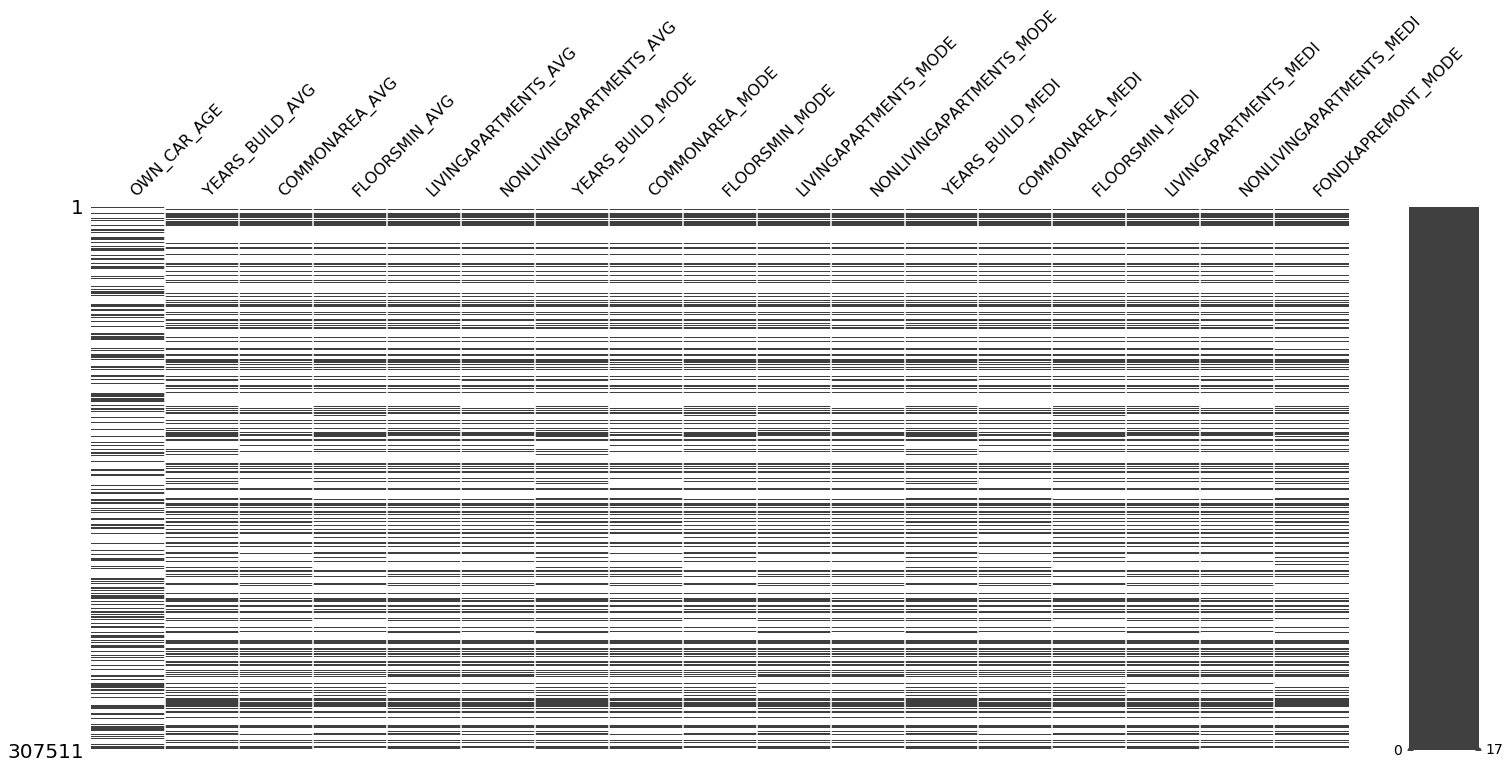

<Figure size 1008x576 with 0 Axes>

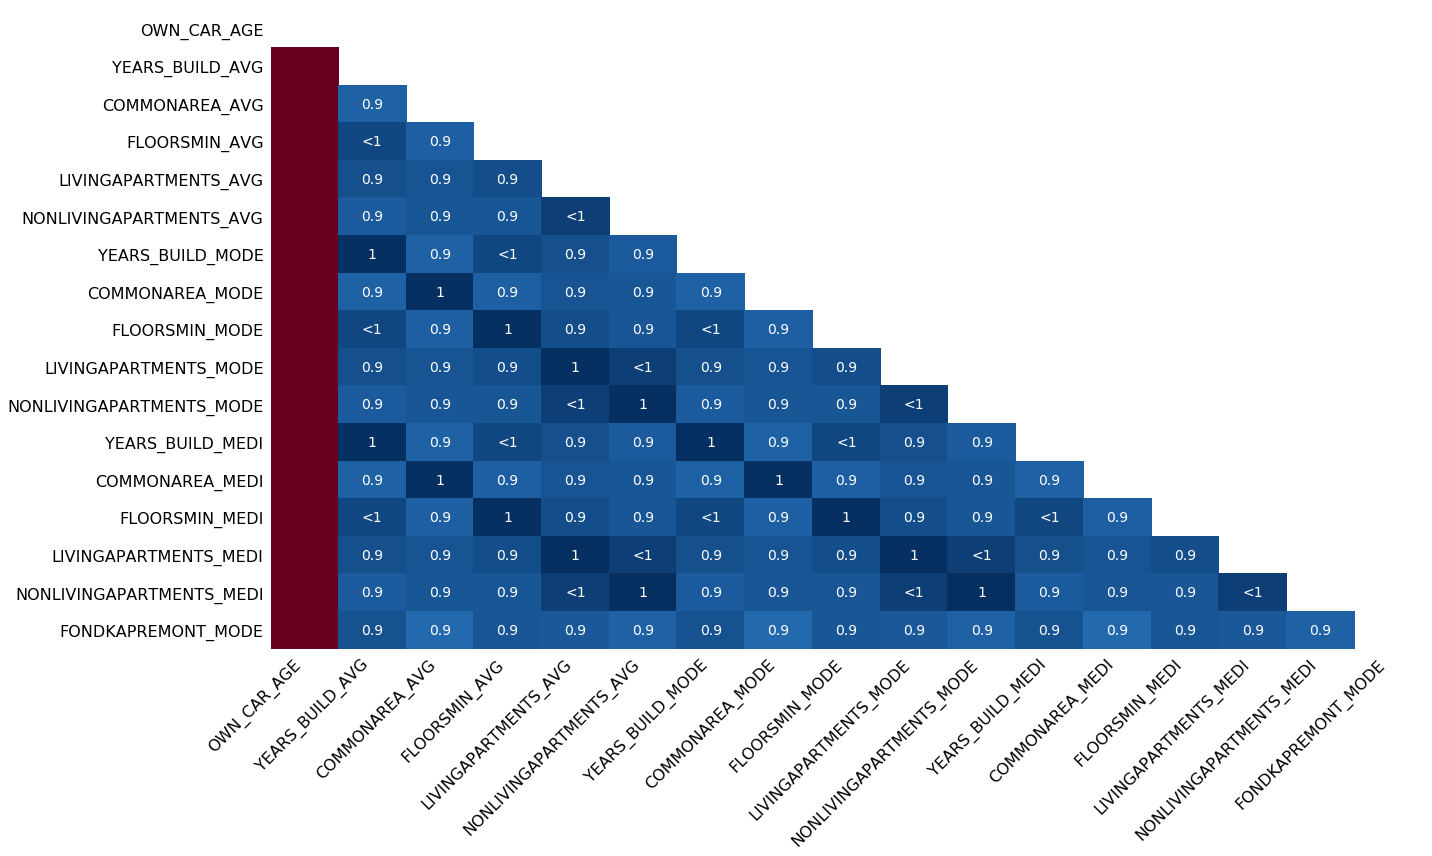

In [10]:
func_eda_df_missingno(df_raw.loc[:,col_names[percent_missing>60]],prefix='above60perc')

### Inferential Statistics

#### Correlation among features

In [86]:
correlations = df_raw.corr()['TARGET'].sort_values() # 2 because the 1st and 2nd rows are ID and Target

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(6))
print('\nMost Negative Correlations:\n', correlations.head(5))

Most Positive Correlations:
 DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3    -0.178919
EXT_SOURCE_2    -0.160472
EXT_SOURCE_1    -0.155317
DAYS_EMPLOYED   -0.044932
FLOORSMAX_AVG   -0.044003
Name: TARGET, dtype: float64


#### Distribution by Gender of Applicants

In [88]:
# summarize the proportion of default cases in each gender group: 1 = Female, 0 = Male.
df_gender = df_raw.loc[:,['CODE_GENDER','TARGET']].groupby('CODE_GENDER').agg(['count','mean'])
display(df_gender)

TARGET          
              count      mean
CODE_GENDER                  
F            202448  0.069993
M            105059  0.101419
XNA               4  0.000000

In [93]:
def _z_test_two_proportion(p, p1, p2, n1, n2): 
    ### calculate z-statistics for two proportion ###
    return np.abs((p1-p2)/np.sqrt(p*(1-p)*(1/n1+1/n2)))

In [94]:
# Calculate z-statistics
p0 = df_gender.loc['F',('TARGET','mean')]
p1 = df_gender.loc['M',('TARGET','mean')]
n0 = df_gender.loc['F',('TARGET','count')]
n1 = df_gender.loc['M',('TARGET','count')]
p = df_raw['TARGET'].mean()
print("z-statistics = {:.1f}".format(_z_test_two_proportion(p, p0, p1, n0, n1)))

z-statistics = 30.3


where,
* "count" represent the total number of applicant in each "GENDER" group. 
* "mean" represents the percentage of applicants that default in each "GENDER" group. 

Thus, the above results suggest that there is a relatively higher chance of default in "male" group. The question to be explored is whether male applicant is more likely to default? 

This can be answered with two proportion z-test: 
* Let p0 = proportion of male default application, 0.101415, and p1 = proportion of female default application, 0.069993. 

Step 1. Establish the Null Hypothesis
* H0: p0 = p1; Ha: p0 != p1; alpha = 0.05;

Step 2. Find the overall proportion
* p = 0.080729

Step 3. Calculate the z-statistics for two proportions
* z = 30.3
<img src="./two-proportion-z-test.png">

Step 4. By looking-up the z-table, the critical z-score associated with alpha/2=0.025 is
* z-score = 1.96

Step 5. Compare the z-statistics against the critical z-score, 
30.3 > 1.96, reject the Null Hypothesis! Thus, there is significant difference between the default rate of male and female applicants, and male applicants are subjected to a higher default rate. 

The script for calculating the z-statistics is shown below. 

## Pre-processing 

### split training and test sets (DataFrame)

In [48]:
# stratified split
label_name = 'TARGET'
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_raw.drop(label_name,axis=1), df_raw[label_name],
                                                                test_size = 0.20, random_state = 42, 
                                                                stratify=df_raw[label_name])

print('Training dataframe shape:', df_X_train.shape)
print('Validation dataframe Shape:', df_X_test.shape)
print('TARGET=1 in training set = {:.2f}%'.format((df_y_train.sum()/df_y_train.shape[0]*100.0)))
print('TARGET=1 in validation set = {:.2f}%'.format((df_y_test.sum()/df_y_test.shape[0]*100.0)))

# # save to pickle
# df_X_train.to_pickle(dir_dat_processed+'/df_X_train.pkl')
# df_y_train.to_pickle(dir_dat_processed+'/df_y_train.pkl')
# df_X_test.to_pickle(dir_dat_processed+'/df_X_test.pkl')
# df_y_test.to_pickle(dir_dat_processed+'/df_y_test.pkl')

Training dataframe shape: (246008, 121)
Validation dataframe Shape: (61503, 121)
TARGET=1 in training set = 8.07%
TARGET=1 in validation set = 8.07%


### pipeline pre-processing

#### General pre-processing

##### (optional) convert numerical to categorical if applicable (e.g. day_of_week = 0, 1, 2, ... , 6)

Features with categorical type will be captured later during one-hot encoding using pd.get_dummies. In this dataset, there is no features that require explicit specification of categorical types. 

##### record feature types

In [15]:
# df['feature'] = df['feature'].astype('category')

In [49]:
feature_dict, feature_df = func_df_col_names_by_type(df_X_train)

with open(dir_dat_processed+'/feature_names.pickle', 'wb') as handle:
    pickle.dump([feature_dict, feature_df], handle, protocol=pickle.HIGHEST_PROTOCOL)

# # Load data 
# with open(dir_dat_processed+'/feature_names.pickle', 'rb') as handle:
#     [feature_dict, feature_df] = pickle.load(handle)

feature_df

,feature_type,feature_num,feature_list
0,cols_number,105,"[SK_ID_CURR, CNT_CHILDREN, AMT_INCOME_TOTAL, A..."
1,cols_string,16,"[NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR..."
2,cols_binary,32,"[FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, ..."
3,cols_number_exclude_binary,73,"[SK_ID_CURR, CNT_CHILDREN, AMT_INCOME_TOTAL, A..."
4,cols_string_include_binary,48,"[NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR..."
5,cols_datetime,0,[]
6,cols_timedelta,0,[]
7,cols_category,0,[]
8,cols_others,0,[]


#### categorical

##### unify string variables to lower case

In [50]:
# unify strings to lower case
df_X_train[feature_dict['cols_string']] = df_X_train[feature_dict['cols_string']].apply(lambda x: x.str.lower())

##### replace known missing values 

In [51]:
# define strings that represents missing values
na_dict = ['xna']
df_X_train = df_X_train.replace(na_dict, np.nan)

##### (opitonal) combine levels in features with high cardinality

Analyse the frequency and response rate of each level within a categorical variable, and decide whether and how levels shall be combined. In this project, no levels are combined. 

In [23]:
df_cat = func_df_cat_levels(df_X_train[feature_dict['cols_string']])
df_cat

,features,level_num,levels
0,NAME_CONTRACT_TYPE,2,"[cash loans, revolving loans]"
1,CODE_GENDER,2,"[f, m, nan]"
2,FLAG_OWN_CAR,2,"[n, y]"
3,FLAG_OWN_REALTY,2,"[n, y]"
15,EMERGENCYSTATE_MODE,2,"[no, nan, yes]"
13,HOUSETYPE_MODE,3,"[block of flats, nan, specific housing, terrac..."
12,FONDKAPREMONT_MODE,4,"[reg oper account, nan, reg oper spec account,..."
6,NAME_EDUCATION_TYPE,5,"[higher education, secondary / secondary speci..."
7,NAME_FAMILY_STATUS,6,"[married, single / not married, civil marriage..."
8,NAME_HOUSING_TYPE,6,"[house / apartment, municipal apartment, with ..."


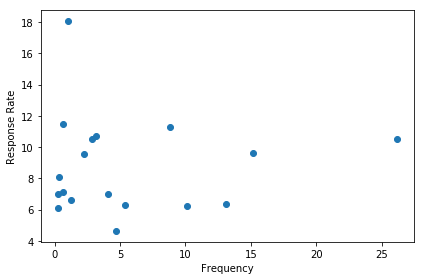

TARGET,0,1,Count,Frequency,Frequnecy,Response_Rate,Frequnecy_Cumu
OCCUPATION_TYPE,,,,,,,
laborers,39602,4657,44259,26.178224,26.18,10.52,26.18
sales staff,23148,2458,25606,15.145385,15.15,9.60,41.33
core staff,20683,1410,22093,13.067523,13.07,6.38,54.40
managers,16032,1064,17096,10.111908,10.11,6.22,64.51
drivers,13261,1683,14944,8.839047,8.84,11.26,73.35
high skill tech staff,8522,571,9093,5.378309,5.38,6.28,78.73
accountants,7517,365,7882,4.662029,4.66,4.63,83.39
medicine staff,6391,480,6871,4.064045,4.06,6.99,87.45
security staff,4798,574,5372,3.177420,3.18,10.69,90.63


In [56]:
df_ct = func_cat_crosstab(df_X_train["OCCUPATION_TYPE"], df_y_train, sortby='Frequency')
display(df_ct)

In [21]:
def func_eda_hist_by_label_plot_hicard(df_X, Y, prefix='', figsize=(6,4), bins=10, dir_png='../reports/figures/'):
    """function to plot the normalized probability density distribution
    Keyword arguments: df_X (feature dataframe), y (label pandas series), dir_png (output dir); Return: PNG files
    """
    import numpy as np
    
    y_uniques = Y.unique()  # unique labels, e.g. 0 or 1
    
    for col in df_X.columns:
        # filter nan vales 
        mask = ~df_X[col].isnull()
        x = df_X.loc[mask, col]
        y = Y[mask]
        
        # plot
        fig = plt.figure(figsize=figsize)
        plt.hist([x[y == y_unique] for y_unique in y_uniques], 
                 label=y_uniques, bins=bins,
                 weights=[np.ones(x[y == y_unique].count()) / x[y == y_unique].count() for y_unique in y_uniques])#density=True)
        plt.xlabel(col)
        plt.xticks(rotation='vertical')
#         plt.ylabel(col)
        plt.legend()
        plt.tight_layout()
#         plt.savefig(dir_reports_figures+'eda-hist-'+prefix+col+'.png')
#         plt.close(fig)
        plt.show()
    
    return

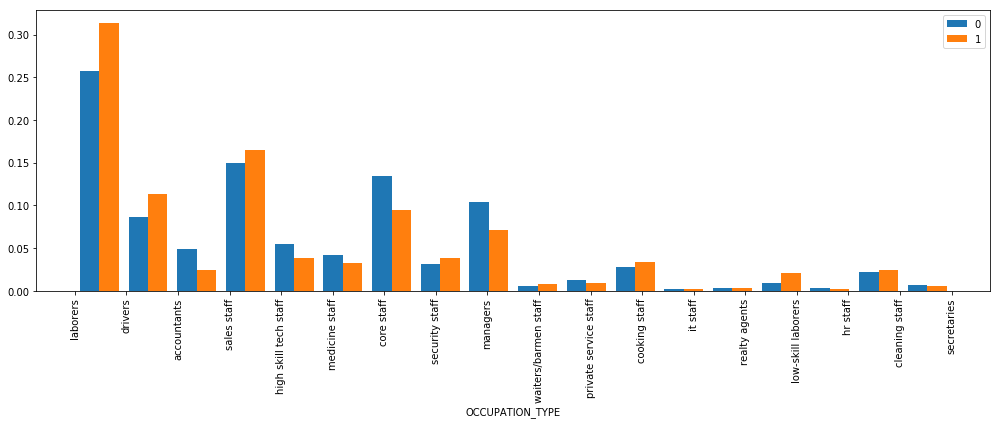

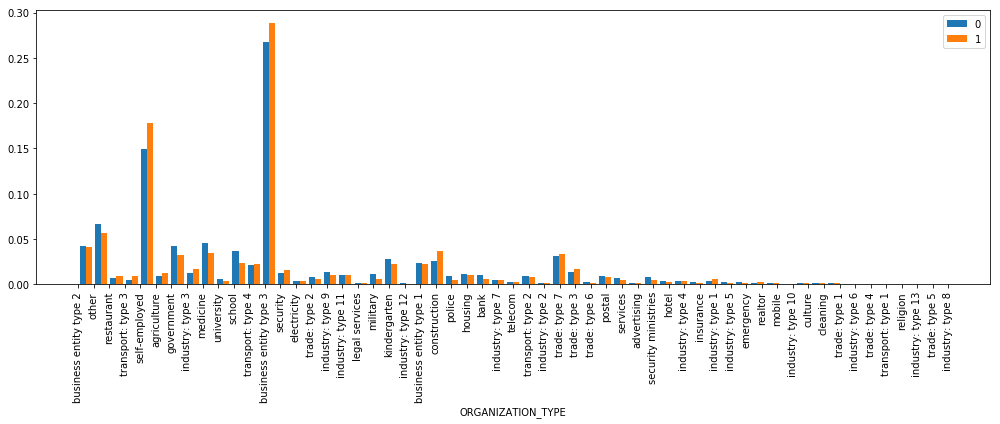

In [22]:
# the plots below lists down the features that have 
func_eda_hist_by_label_plot_hicard(df_X_train[['OCCUPATION_TYPE']], df_y_train, figsize=(14,6), bins=18)
func_eda_hist_by_label_plot_hicard(df_X_train[['ORGANIZATION_TYPE']], df_y_train, figsize=(14,6), bins=57)

##### one-hot encoding, add column for nan

Encode both string and categorical features. 

In [57]:
print('training data shape before one-hot encoding = {}'.format(df_X_train.shape))
df_X_train = pd.get_dummies(df_X_train,columns=(feature_dict['cols_string'] + feature_dict['cols_category']),dummy_na=True, dtype=float)
print('training data shape after one-hot encoding = {}'.format(df_X_train.shape))

training data shape before one-hot encoding = (246008, 121)
training data shape after one-hot encoding = (246008, 259)


#### numerical (continuous variables)

##### remove outliers

In [58]:
df_X_train.loc[df_X_train['DAYS_EMPLOYED']>0,'DAYS_EMPLOYED'] = np.nan

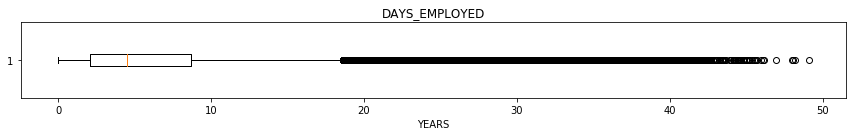

In [59]:
fig = plt.figure(figsize=(12,2))
plt.boxplot(df_X_train['DAYS_EMPLOYED'].dropna()/-365, vert=False)
plt.title('DAYS_EMPLOYED')
plt.xlabel('YEARS')
plt.tight_layout()
plt.show()

#### binary variables

##### convert True/False to 1/0 (if any)

In [60]:
df_X_train[feature_dict['cols_binary']] = df_X_train[feature_dict['cols_binary']] * 1  # True * 1 = 1

#### inpute missing values & scaling (numerical features)

Note the difference between numerical and binary-numerical features. Here, the plan is to
* fill 'median' values for numerical
* fill 'most frequent' values for binary features so that the output is always 0 or 1

##### (optional) mark existence of NaN values for selected features

Create an additional column 'feature_nan' to mark if a value is NaN. Use when the existence of values infers any meaning during data collection or interpretation. 

In [63]:
# columns with missing values 
col_w_missing_values = df_X_train.columns.values[df_X_train.isnull().sum()>0]

# or directly specify which features we would like to monitor the existence of missing values 
col_w_missing_values = ['CODE_GENDER']

# In this example, we do not monitor the missing value of any features 
col_w_missing_values = []

# example usage 
df_X_train = func_df_add_missing_flag(df_X_train, col_w_missing_values)

##### Scale and impute numerical values

In [64]:
# numerical features: use median imputer, standard scaler
scaler_standard = StandardScaler()
imp_median = SimpleImputer(strategy='median')

df_X_train[feature_dict['cols_number_exclude_binary']] = scaler_standard.fit_transform(df_X_train[feature_dict['cols_number_exclude_binary']])
df_X_train[feature_dict['cols_number_exclude_binary']] = imp_median.fit_transform(df_X_train[feature_dict['cols_number_exclude_binary']])

C:\Users\zb\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\zb\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


##### Impute binary values

In [65]:
# binary features: use most_frequent, no need scaling
imp_most_freq = SimpleImputer(strategy='most_frequent')
df_X_train[feature_dict['cols_binary']] = imp_most_freq.fit_transform(df_X_train[feature_dict['cols_binary']])

##### check inputation and scaling parameters

In [66]:
# print(imp_median.statistics_)
# print(imp_most_freq.statistics_)

#### Select features to be included (used to ensure consistency in Testing Data)

In [67]:
col_X_train = df_X_train.columns.values
display(df_X_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246008 entries, 181648 to 285162
Columns: 259 entries, SK_ID_CURR to EMERGENCYSTATE_MODE_nan
dtypes: float64(227), int64(32)
memory usage: 488.0 MB


None

### Pipeline for testing data

#### Apply the same pipeline as training data

In [68]:
## Genenral pre-processing: 
# unify to lower case
df_X_test[feature_dict['cols_string']] = df_X_test[feature_dict['cols_string']].apply(lambda x: x.str.lower())
# replace known missing values
df_X_test = df_X_test.replace(na_dict, np.nan)

## Categorical features
# One-hot encoding, and align column names
df_X_test = pd.get_dummies(df_X_test,columns=(feature_dict['cols_string'] + feature_dict['cols_category']),dummy_na=True, dtype=float)


## Numerical features
# Remove outliers 
df_X_test.loc[df_X_test['DAYS_EMPLOYED']>0,'DAYS_EMPLOYED'] = np.nan

## Binary features
# Conert True/False to 1/0 (if any)
df_X_test[feature_dict['cols_binary']] = df_X_test[feature_dict['cols_binary']] * 1  # True * 1 = 1

## Add missing columns
df_X_test = func_df_add_missing_flag(df_X_test, col_w_missing_values)

# Allignment of Features [additional step for testing data, before any imputation] 
# Get missing columns in the training test (which corresponds to levels that existing in training but not in test dataset for categorical variables)
missing_cols = set( df_X_train.columns ) - set( df_X_test.columns )
# Add a missing column in test set with default value equal to 0 (i.e., indicating this level does not exists)
for c in missing_cols:
    df_X_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
df_X_test = df_X_test[df_X_train.columns]

## Impute missing values and scaling
# Scale and impute numerical features
df_X_test[feature_dict['cols_number_exclude_binary']] = scaler_standard.transform(df_X_test[feature_dict['cols_number_exclude_binary']])
df_X_test[feature_dict['cols_number_exclude_binary']] = imp_median.transform(df_X_test[feature_dict['cols_number_exclude_binary']])

# Impute binary features
df_X_test[feature_dict['cols_binary']] = imp_most_freq.transform(df_X_test[feature_dict['cols_binary']])


C:\Users\zb\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


#### Check dimension

In [69]:
print('training data x: {}'.format(df_X_train.shape))
print('test data x : {}'.format(df_X_test.shape))
print('training data y: {}'.format(df_y_train.shape))
print('test data y: {}'.format(df_y_test.shape))

training data x: (246008, 259)
test data x : (61503, 259)
training data y: (246008,)
test data y: (61503,)


#### target: check if need to convert to numeric

In [70]:
df_y_train = func_df_series_categorization(df_y_train)
df_y_train = func_df_series_categorization(df_y_train)

no need to covert. already numerical.
no need to covert. already numerical.


#### save pre-processed data

In [71]:
# save to pickle, ver0, raw split data
with open(dir_dat_processed+'/df_X_train.pickle', 'wb') as handle:
    pickle.dump(df_X_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(dir_dat_processed+'/df_X_test.pickle', 'wb') as handle:
    pickle.dump(df_X_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(dir_dat_processed+'/df_y_train.pickle', 'wb') as handle:
    pickle.dump(df_y_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(dir_dat_processed+'/df_y_test.pickle', 'wb') as handle:
    pickle.dump(df_y_test, handle, protocol=pickle.HIGHEST_PROTOCOL)    


### Hot-start: Load Pre-processed Data

In [39]:
import pickle
with open(dir_dat_processed+'/df_X_train.pickle', 'rb') as handle:
    df_X_train = pickle.load(handle)
with open(dir_dat_processed+'/df_X_test.pickle', 'rb') as handle:
    df_X_test = pickle.load(handle)
with open(dir_dat_processed+'/df_y_train.pickle', 'rb') as handle:
    df_y_train = pickle.load(handle)
with open(dir_dat_processed+'/df_y_test.pickle', 'rb') as handle:
    df_y_test = pickle.load(handle)    


In [40]:
X_train = df_X_train.values
X_test = df_X_test.values
y_train = df_y_train.values
y_test = df_y_test.values

In [41]:
del df_X_train, df_X_test, df_y_train, df_y_test

## Model Selection (Qick Assessment with Under Sampling)

Quick assessment with smaller samples. 

### Under Sampling of Dataset

In [72]:
from imblearn.under_sampling import RandomUnderSampler

In [84]:
rus = RandomUnderSampler(return_indices=True, random_state=42)
%time X_rus, y_rus, id_rus = rus.fit_sample(df_X_train, df_y_train)

print('Original X size = {}'.format(df_X_train.shape))
print('Original y size = {}'.format(df_y_train.shape))
print('Under sampled X size = {}'.format(X_rus.shape))
print('Under sampled y size = {}'.format(y_rus.shape))

Wall time: 674 ms
Original X size = (246008, 259)
Original y size = (246008,)
Under sampled X size = (39720, 259)
Under sampled y size = (39720,)


In [85]:
np.unique(y_rus,return_counts=True)  # check y balance

(array([0, 1], dtype=int64), array([19860, 19860], dtype=int64))

### Cross-validation

In [104]:
from sklearn.model_selection import cross_validate

In [136]:
start = time.time()
v = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
models = [GaussianNB(),
          LogisticRegression(random_state=42, verbose=0, n_jobs=-1, solver='lbfgs'), 
          RandomForestClassifier(n_estimators=100, random_state=42, verbose=1, n_jobs=-1),
          GradientBoostingClassifier(n_estimators=100, random_state=42, verbose=1),
          XGBClassifier(random_state=42, verbose=1, n_jobs=-1)
         ]
names = ["Naive Bayes","Logistic","RandomForest","GradientBoosting","XGBoosting"]

df_scores = pd.DataFrame()

for model, name in zip(models, names):
    print("Executing {} model.".format(name))
    start = time.time()
    scoring = {'acc': 'accuracy',
               'prec': 'precision',
               'rec': 'recall',
               'f1': 'f1', 
               'roc_auc': 'roc_auc'}
    score = cross_validate(model, X_rus, y_rus, scoring=scoring,
                             cv=cv, return_train_score=False)
    df_score = pd.DataFrame(score)
    df_score.index = df_score.index.set_names(['cv'])
    df_score.reset_index(inplace=True)
    df_score.insert(loc=0, column='Name', value=name)
    df_scores = pd.concat([df_scores, df_score])
    
print("Total execution time = {} min.".format((time.time() - start)/60.0))

Executing Naive Bayes model.
Executing Logistic model.
Executing RandomForest model.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=

Executing GradientBoosting model.
      Iter       Train Loss   Remaining Time 
         1           1.3643           42.27s
         2           1.3460           41.70s
         3           1.3305           41.35s
         4           1.3173           40.85s
         5           1.3060           40.43s
         6           1.2963           39.86s
         7           1.2874           39.22s
         8           1.2796           38.71s
         9           1.2729           38.25s
        10           1.2667           38.41s
        20           1.2272           33.15s
        30           1.2048           29.11s
        40           1.1912           24.63s
        50           1.1811           20.58s
        60           1.1729           16.36s
        70           1.1660           12.25s
        80           1.1603            8.15s
        90           1.1557            4.06s
       100           1.1510            0.00s
      Iter       Train Loss   Remaining Time 
         1         

In [139]:
with open(dir_reports+'/cv_model_selection.pickle', 'wb') as handle:
    pickle.dump(df_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [137]:
# save cross-validation results and compare model performances 
df_scores.groupby('Name').agg(['mean','std']).T

Name               GradientBoosting  Logistic  Naive Bayes  RandomForest  \
cv           mean          2.000000  2.000000     2.000000      2.000000   
             std           1.581139  1.581139     1.581139      1.581139   
fit_time     mean         41.281400  8.759200     0.192000      5.350000   
             std           0.792911  0.693370     0.003674      0.352517   
score_time   mean          0.179200  0.031200     0.259800      1.097200   
             std           0.020401  0.003271     0.004087      0.057686   
test_acc     mean          0.684668  0.681219     0.558359      0.672885   
             std           0.005542  0.002379     0.010952      0.003939   
test_prec    mean          0.684788  0.683578     0.538743      0.681128   
             std           0.004353  0.004033     0.008854      0.006290   
test_rec     mean          0.684290  0.674874     0.817825      0.650302   
             std           0.009209  0.003967     0.024617      0.004826   
test_f1      mean          0.684529  0.679183     0.649312      0.665331   
             std           0.006624  0.001748     0.002481      0.002828   
test_roc_auc mean          0.749074  0.743590     0.624188      0.733938   
             std           0.005526  0.004782     0.001123      0.005607   

Name               XGBoosting  
cv           mean    2.000000  
             std     1.581139  
fit_time     mean   19.993200  
             std     2.406601  
score_time   mean    0.391800  
             std     0.078818  
test_acc     mean    0.684894  
             std     0.005942  
test_prec    mean    0.684982  
             std     0.004435  
test_rec     mean    0.684592  
             std     0.010756  
test_f1      mean    0.684771  
             std     0.007365  
test_roc_auc mean    0.749054  
             std     0.006193

Based on the above comparison, XGBoosting provides the best results, followed by Logistic Regression, and RandomForest

## Test with Oversampling

Test if there will be any boost in performance using upsampling. 

### Oversampling using SMOTE

In [42]:
%%time
# upsampling 
from imblearn.over_sampling import SMOTE
X_upsampled, y_upsampled = SMOTE().fit_resample(df_X_train, df_y_train)

Wall time: 3min 38s


In [43]:
print(X_train.shape)
print(y_train.shape)
print(X_upsampled.shape)
print(y_upsampled.shape)
# save to pickle
with open(dir_dat_processed+"X_upsampled.pickle", 'wb') as handle:
    pickle.dump(X_upsampled, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(dir_dat_processed+"y_upsampled.pickle", 'wb') as handle:
    pickle.dump(y_upsampled, handle, protocol=pickle.HIGHEST_PROTOCOL)

(246008, 259)
(246008,)
(452296, 259)
(452296,)


In [22]:
# read from pickle
with open(dir_dat_processed+"X_upsampled.pickle", 'rb') as handle:
    X_upsampled = pickle.load(handle)
with open(dir_dat_processed+"y_upsampled.pickle", 'rb') as handle:
    y_upsampled = pickle.load(handle)
    

### Cross-validation

In [141]:
start = time.time()
v = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
models = [GaussianNB(),
          LogisticRegression(random_state=42, verbose=0, n_jobs=-1, solver='lbfgs'), 
          RandomForestClassifier(n_estimators=200, random_state=42, verbose=1, n_jobs=-1),
          GradientBoostingClassifier(n_estimators=200, random_state=42, verbose=1),
          XGBClassifier(random_state=42, verbose=1, n_jobs=-1)
         ]
names = ["Naive Bayes","Logistic","RandomForest","GradientBoosting","XGBoosting"]

df_scores = pd.DataFrame()

for model, name in zip(models, names):
    print("Executing {} model.".format(name))
    start = time.time()
    scoring = {'acc': 'accuracy',
               'prec': 'precision',
               'rec': 'recall',
               'f1': 'f1', 
               'roc_auc': 'roc_auc'}
    score = cross_validate(model, X_upsampled, y_upsampled, scoring=scoring,
                             cv=cv, return_train_score=False)
    df_score = pd.DataFrame(score)
    df_score.index = df_score.index.set_names(['cv'])
    df_score.reset_index(inplace=True)
    df_score.insert(loc=0, column='Name', value=name)
    df_scores = pd.concat([df_scores, df_score])
    
print("Total execution time = {} min.".format((time.time() - start)/60.0))

Executing Naive Bayes model.
Executing Logistic model.
Executing RandomForest model.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | 

Executing GradientBoosting model.
      Iter       Train Loss   Remaining Time 
         1           1.3449           20.90m
         2           1.3107           20.96m
         3           1.2812           21.67m
         4           1.2411           21.85m
         5           1.2130           22.03m
         6           1.1840           22.09m
         7           1.1619           21.94m
         8           1.1381           21.82m
         9           1.1178           21.75m
        10           1.0956           21.62m
        20           0.8970           20.45m
        30           0.7647           19.14m
        40           0.6745           17.96m
        50           0.6031           16.79m
        60           0.5519           15.59m
        70           0.5072           14.46m
        80           0.4724           13.29m
        90           0.4422           12.16m
       100           0.4230           11.01m
       200           0.3206            0.00s
      Iter       Tra

In [142]:
with open(dir_reports+'/cv_model_selection_oversampled.pickle', 'wb') as handle:
    pickle.dump(df_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [143]:
# save cross-validation results and compare model performances 
df_scores.groupby('Name').agg(['mean','std']).T

Name               GradientBoosting   Logistic  Naive Bayes  RandomForest  \
cv           mean          2.000000   2.000000     2.000000      2.000000   
             std           1.581139   1.581139     1.581139      1.581139   
fit_time     mean       1350.045200  15.683800     2.254200    196.974000   
             std          57.356621   0.378942     0.057312      7.920153   
score_time   mean          3.735400   0.280000     3.131400     13.294400   
             std           0.219875   0.010536     0.188170      0.687090   
test_acc     mean          0.953557   0.703878     0.559242      0.957769   
             std           0.001142   0.000810     0.001951      0.001166   
test_prec    mean          0.998479   0.700800     0.534416      0.999763   
             std           0.000227   0.000687     0.001347      0.000063   
test_rec     mean          0.908498   0.711543     0.920092      0.915754   
             std           0.002269   0.002512     0.004605      0.002310   
test_f1      mean          0.951364   0.706129     0.676115      0.955915   
             std           0.001253   0.001232     0.000823      0.001270   
test_roc_auc mean          0.976010   0.771794     0.583704      0.989592   
             std           0.000845   0.000223     0.004928      0.000363   

Name               XGBoosting  
cv           mean    2.000000  
             std     1.581139  
fit_time     mean  190.927600  
             std     0.419353  
score_time   mean    3.330400  
             std     0.023808  
test_acc     mean    0.948761  
             std     0.001373  
test_prec    mean    0.997257  
             std     0.000349  
test_rec     mean    0.899999  
             std     0.002844  
test_f1      mean    0.946133  
             std     0.001526  
test_roc_auc mean    0.973968  
             std     0.000784

## GridSearch

In [75]:
## hyper-parameters that can be tuned 

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 3)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']  #  259, 16, 8

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 3)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap}

random_grid

{'n_estimators': [200, 350, 500],
 'max_features': ['auto', 'sqrt', 'log2'],
 'max_depth': [10, 20, 30, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [10]:
## hyper-parameters that can be tuned 

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 3)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']  #  259, 16, 8

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 3)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
    'clf_rf__n_estimators': n_estimators,
    'clf_rf__max_features': max_features,
    'clf_rf__max_depth': max_depth,
    'clf_rf__min_samples_split': min_samples_split,
    'clf_rf__min_samples_leaf': min_samples_leaf,
    'clf_rf__bootstrap': bootstrap}


# # grid search
clf_rf_base = RandomForestClassifier(verbose=2, random_state=42, n_jobs=2)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
pipeline = Pipeline([('sampling', SMOTE()),
                  ('clf_rf', clf_rf_base)
                 ])


# clf_rf_gs = GridSearchCV(estimator=clf_rf_base, 
#                          param_grid=random_grid, 
#                          cv=5, scoring='roc_auc', 
#                          verbose=1, n_jobs=-1)
# clf_rf_gs.fit(X_upsampled,y_upsampled)

kf = StratifiedKFold(n_splits=5)

clf_rf_rs = RandomizedSearchCV(estimator = pipeline, 
                               param_distributions = random_grid, 
                               scoring='roc_auc',
                               n_iter = 30, 
                               cv = kf, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = 2)

clf_rf_rs.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 239.2min
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed: 867.4min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.4min


building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80

[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  6.1min


building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500


[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed: 14.0min


building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500


[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed: 19.3min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
          error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('sampling', SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
   out_step='deprecated', random_state=None, ratio=None,
   sampling_strategy='auto', svm_estimator='deprecated')), ('clf_rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
 ...ators='warn', n_jobs=2,
            oob_score=False, random_state=42, verbose=2, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=30, n_jobs=2,
          param_distributions={'clf_rf__n_estimators': [200, 350, 500], 'clf_rf__max_features': ['auto', 'sqrt', 'log2'], 'clf_rf__max_depth': [10, 20, 30, None], 'clf_rf__min_samples_split': [2, 5, 10], 'clf_rf__min_samples_leaf': [1, 2, 4], 'clf_rf__bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          retur

In [12]:
print("Best parameters set found on development set:")
print()
print(clf_rf_rs.best_estimator_)
print()
print("Grid scores on development set:")
print()
means = clf_rf_rs.cv_results_['mean_test_score']
stds = clf_rf_rs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_rf_rs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

with open(dir_reports+'/clf_rf_gs.pickle', 'wb') as handle:
    pickle.dump(clf_rf_rs, handle, protocol=pickle.HIGHEST_PROTOCOL)

Best parameters set found on development set:

Pipeline(memory=None,
     steps=[('sampling', SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
   out_step='deprecated', random_state=None, ratio=None,
   sampling_strategy='auto', svm_estimator='deprecated')), ('clf_rf', RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
...timators=500, n_jobs=2,
            oob_score=False, random_state=42, verbose=2, warm_start=False))])

Grid scores on development set:

0.715 (+/-0.011) for {'clf_rf__n_estimators': 500, 'clf_rf__min_samples_split': 5, 'clf_rf__min_samples_leaf': 2, 'clf_rf__max_features': 'log2', 'clf_rf__max_depth': None, 'clf_rf__bootstrap': False}
0.705 (+/-0.013) for {'clf_rf__n_estimators': 350, 'clf_rf__min_samples_split': 5, 'clf_rf__min_samples_leaf': 1, 'clf_rf__max_features': 'log2', 'clf_rf__max_depth': 30, 'clf_rf__bootstrap': True}
0.722 (+/-0.011) for {'clf_rf__n_estimators': 500, 'clf_rf__min_samples_split': 10, 'clf

In [19]:
clf_rf_rs_best = clf_rf_rs.best_estimator_.steps[1][1]

In [20]:
clf_rf_rs_best.fit(X_train,y_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   39.8s


building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80

[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  2.8min


building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500


[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:  6.2min


building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500


[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  8.6min finished


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=2,
            oob_score=False, random_state=42, verbose=2, warm_start=False)

In [21]:
fpr, tpr, thresholds = roc_curve(y_train, clf_rf_rs_best.predict_proba(X_train)[:, 1])
roc_auc = auc(fpr, tpr)
print('train auc = {}'.format(roc_auc))

fpr, tpr, thresholds = roc_curve(y_test, clf_rf_rs_best.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
print('test auc = {}'.format(roc_auc))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   10.9s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   26.9s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   38.6s finished


train auc = 0.9999973769283084


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:    5.7s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    8.0s finished


test auc = 0.7398161426921486


## Final Model

### Load best model from GridSearch

In [25]:
with open(dir_reports+'/clf_rf_gs.pickle', 'wb') as handle:
    pickle.dump(clf_rf_rs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
clf_rf_rs_best = clf_rf_rs.best_estimator_.steps[1][1]

In [27]:
clf_rf_rs_best

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=2,
            oob_score=False, random_state=42, verbose=2, warm_start=False)

### Train with over-sampled (balanced) dataset

In [28]:
clf_rf_rs_best.fit(X_upsampled,y_upsampled)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.5min


building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80

[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  6.1min



building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500

[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed: 13.7min


building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500


[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed: 18.9min finished


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=2,
            oob_score=False, random_state=42, verbose=2, warm_start=False)

In [42]:
y_pred_train = clf_rf_rs_best.predict(X_train)

print("Test accuracy = {:.6f}".format(accuracy_score(y_train, y_pred_train)))

unique_label = np.unique(y_train)
cm = confusion_matrix(y_train, y_pred_train, labels=unique_label)
print(pd.DataFrame(cm, 
                   index=['true:{:}'.format(x) for x in unique_label],
                   columns=['pred:{:}'.format(x) for x in unique_label]))

cr = classification_report(y_train, y_pred_train, output_dict=True)
cr_df = pd.DataFrame(cr)
display(cr_df)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   12.3s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   27.7s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   38.6s finished


Test accuracy = 0.969066
        pred:0  pred:1
true:0  226148       0
true:1    7610   12250


,0,1,micro avg,macro avg,weighted avg
f1-score,0.983453,0.763002,0.969066,0.873228,0.965656
precision,0.967445,1.000000,0.969066,0.983722,0.970073
recall,1.000000,0.616818,0.969066,0.808409,0.969066
support,226148.000000,19860.000000,246008.000000,246008.000000,246008.000000


In [29]:
with open(dir_reports+'/clf_rf_rs_best_trained.pickle', 'wb') as handle:
    pickle.dump(clf_rf_rs_best, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Model Performance

In [30]:
# Prediction Training and Test
y_pred_test = clf_rf_rs_best.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:    5.7s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    8.0s finished


In [33]:
print("Test accuracy = {:.6f}".format(accuracy_score(y_test, y_pred_test)))

unique_label = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred_test, labels=unique_label)
print(pd.DataFrame(cm, 
                   index=['true:{:}'.format(x) for x in unique_label],
                   columns=['pred:{:}'.format(x) for x in unique_label]))

cr = classification_report(y_test, y_pred_test, output_dict=True)
cr_df = pd.DataFrame(cr)
display(cr_df)

Test accuracy = 0.919305
        pred:0  pred:1
true:0   56534       4
true:1    4959       6


,0,1,micro avg,macro avg,weighted avg
f1-score,0.957952,0.002412,0.919305,0.480182,0.880813
precision,0.919357,0.600000,0.919305,0.759678,0.893576
recall,0.999929,0.001208,0.919305,0.500569,0.919305
support,56538.000000,4965.000000,61503.000000,61503.000000,61503.000000


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:    6.4s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    8.9s finished


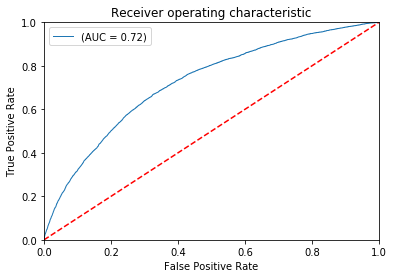

In [35]:
from sklearn.metrics import roc_curve, auc
probas_ = clf_rf_rs_best.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=1.0, label='(AUC = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend()
plt.show()

## Model Interpretation

### Feature Importance

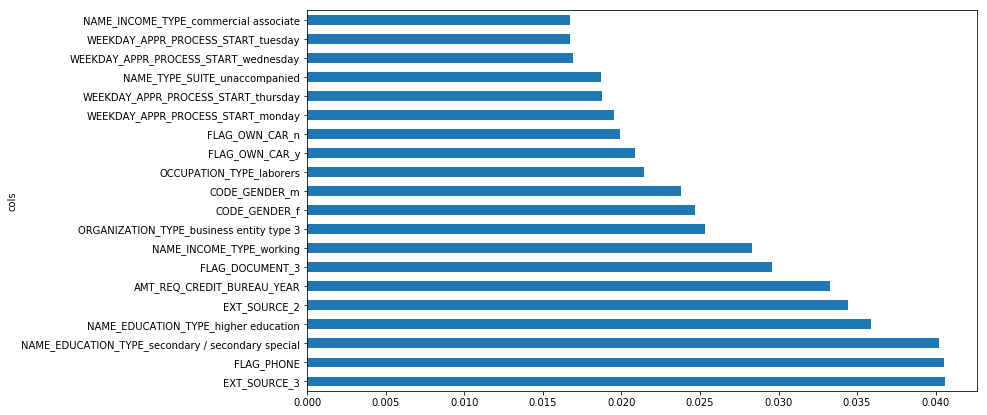

In [65]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
# feature importance
fi = rf_feat_importance(clf_rf_rs_best, df_X_train)
plot_fi(fi[:20])
plt.show()

In [66]:
# ## function to plot feature importance from a trained RandomForest model, and output importance in dataframe format
# def func_rf_feature_importance(clf, features, figsize=(4,6), pngname=''):
#     """function to plot feature importance from a trained RandomForest model, and output importance in dataframe format
#     Keyword arguments: clf (rf classifier), features (list of names), Optional: figsize, pngname; Return: PNG file, df_fi
#     """
    
    
#     importances = clf.feature_importances_
#     indices = np.argsort(importances)
    
#     plt.figure(figsize=figsize)
#     plt.title('Feature Importances')
#     plt.barh(range(len(indices)), importances[indices], align='center')
#     plt.yticks(range(len(indices)), [features[i] for i in indices])
#     plt.xlabel('Relative Importance')
#     plt.tight_layout()
#     plt.show()
#     if pngname:
#         plt.savefig(pngname)
    
#     df_fi = pd.DataFrame({'feature': features,'importance': importances})
#     df_fi.sort_values(by=['importance'], ascending=False, inplace=True)
    
#     return df_fi

In [63]:
# with open(dir_dat_processed+'/df_X_train.pickle', 'rb') as handle:
#     df_X_train = pickle.load(handle)

In [67]:
# df_fi = func_rf_feature_importance(clf_rf_rs_best, df_X_train.columns, figsize=(14,26), 
#                                     pngname=dir_reports_figures+'rf_feature_importance.png')

### Permutation Importance

In [43]:
with open(dir_dat_processed+'/df_X_train.pickle', 'rb') as handle:
    df_X_train = pickle.load(handle)
with open(dir_dat_processed+'/df_y_train.pickle', 'rb') as handle:
    df_y_train = pickle.load(handle)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   12.1s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   27.0s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   37.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   11.6s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   27.0s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   37.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   11.5s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   26.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   36.2s finished
[

[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   27.8s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   39.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   12.0s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   30.5s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   41.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   12.2s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   28.6s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   40.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   14.5s
[

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   11.5s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   26.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   36.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   11.4s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   25.8s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   36.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   11.4s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   26.7s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   38.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   11.1s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   25.7s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   35.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   11.1s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   25.6s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   36.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   11.1s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   25.5s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   35.4s finished
[

[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   27.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   36.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   12.6s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   28.7s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   38.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   12.8s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   29.7s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   39.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   11.3s
[

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   11.9s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   27.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   37.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   13.3s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   27.5s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   37.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   12.0s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   26.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   35.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   11.4s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   26.0s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   36.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   11.3s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   25.7s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   35.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   11.5s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   26.5s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   37.1s finished
[

[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   26.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   36.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   10.9s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   24.9s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   34.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   12.5s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   26.9s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   36.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   12.7s
[

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   11.9s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   26.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   35.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   11.5s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   26.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   36.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   11.4s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   26.5s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   37.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   11.0s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   25.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   35.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   12.0s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   28.5s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   39.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   11.3s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   26.5s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   36.5s finished
[

[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   25.4s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   35.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   11.4s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   26.3s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   36.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   11.2s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   25.7s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   35.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   11.1s
[

,Importance
Feature,
EXT_SOURCE_3,0.033064
EXT_SOURCE_2,0.032727
AMT_REQ_CREDIT_BUREAU_YEAR,0.019349
FLAG_PHONE,0.017609
NAME_INCOME_TYPE_working,0.017134
EXT_SOURCE_1,0.016398
FLAG_DOCUMENT_3,0.015634
DAYS_LAST_PHONE_CHANGE,0.015451
AMT_GOODS_PRICE,0.015121


9875.022000074387


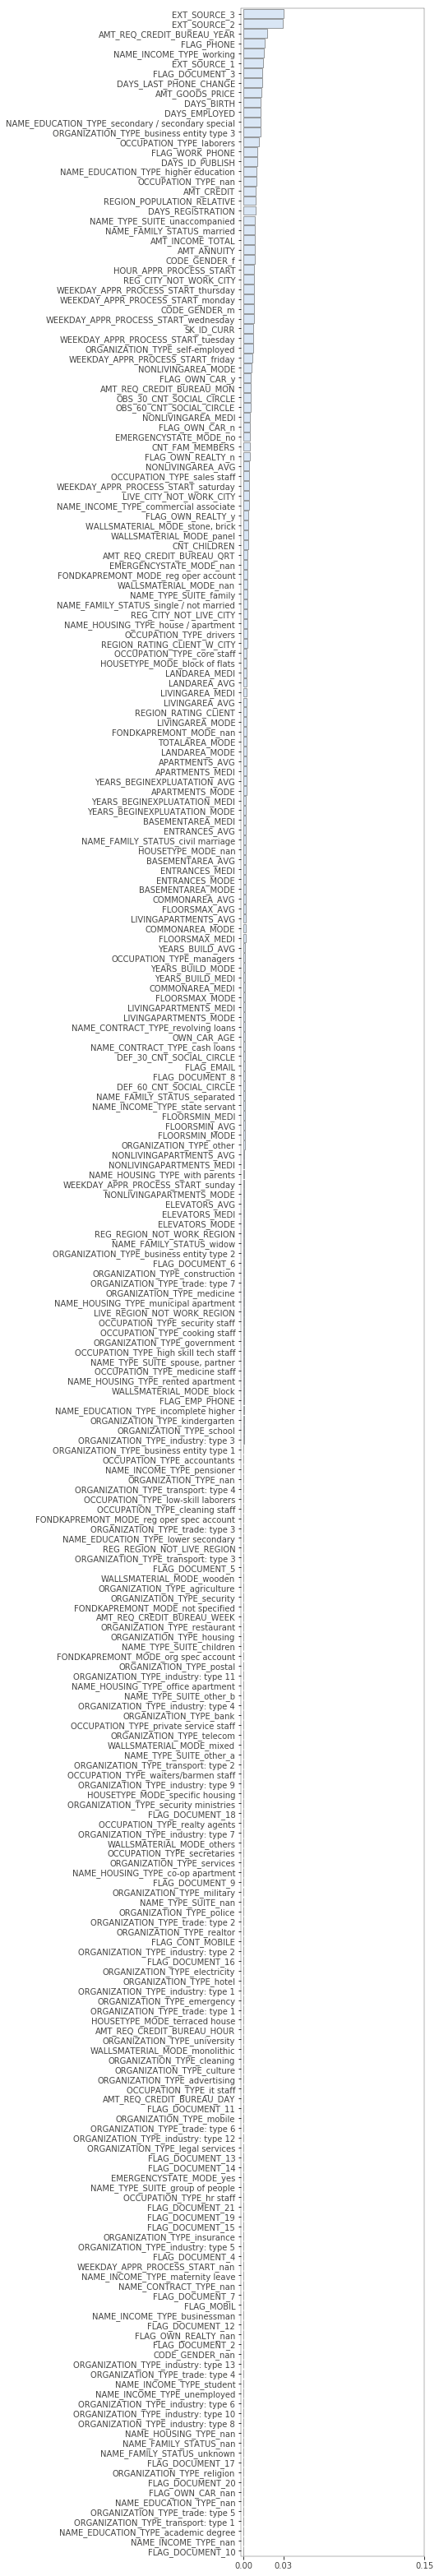

In [78]:
from rfpimp import *
start = time.time()
df_rfpimp_imp = importances(clf_rf_rs_best, df_X_train, df_y_train, n_samples=-1) # permutation
plot_importances(df_rfpimp_imp,minheight=4)
display(df_rfpimp_imp)
print(time.time() - start)

### SHAP: Individual Analysis

In [73]:
# take one single dataset
row_to_show = 90
data_for_prediction = X_train[row_to_show,:]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.reshape(1, -1)
clf_rf_rs_best.predict_proba(data_for_prediction_array)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.0s finished


array([[0.95193254, 0.04806746]])

In [51]:
import shap
explainer = shap.TreeExplainer(clf_rf_rs_best)
shap_values = explainer.shap_values(data_for_prediction)

In [52]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction, 
                show=True, matplotlib=False)

In [53]:
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction, 
                show=True, matplotlib=False)

In [77]:
df_shap_values = pd.DataFrame({'feature':df_X_train.columns,'pos':shap_values[0]})
df_shap_values.sort_values(by=['pos'], ascending=False, inplace=True)
display(df_shap_values.head(5))
display(df_shap_values.tail(5))

,feature,pos
29,EXT_SOURCE_2,0.049855
16,FLAG_PHONE,0.045225
132,NAME_INCOME_TYPE_working,0.042862
112,FLAG_OWN_CAR_y,0.034540
111,FLAG_OWN_CAR_n,0.024946


,feature,pos
80,FLAG_DOCUMENT_3,-0.002314
138,NAME_EDUCATION_TYPE_secondary / secondary special,-0.002318
236,ORGANIZATION_TYPE_transport: type 4,-0.003564
8,DAYS_EMPLOYED,-0.003880
11,OWN_CAR_AGE,-0.006224
